# Задача:
https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ 
ДЗ - оценить возраст человека по изображению. В качестве датасета возьмите датасет только лиц. 
Предположим что сами лица вы находить и извлекать уже умеете. Можете сделать это как продолжение решения по поиску лиц из предыдущих работ.
https://www.google.com/amp/s/www.geeksforgeeks.org/age-detection-using-deep-learning-in-opencv/amp/ пример того как это может работать.  
В качестве фьючеэкстрактора берите любую современную нейронную сеть. Задачу можно решать как задачу регрессии или классификации.  14 14-18 
Если есть время можете попробовать 2 способа.  Попробуйте разблокировать часть слоев после обучения и дообучить модель.


0-14 14-17 18-21 22-


Указание -  что бы решить задачу регресси вам нужно использовать flow_from_dataframe
Указание - для начала вам нужно создать датафрейм в котором будет относительный путь к изображению и целевая метка, потом использовать этот датафрейм при обучении

In [1]:
from keras import models
from keras import optimizers
from keras import layers
from keras.metrics import AUC
from matplotlib import pyplot as plt
import numpy as np
import tarfile
import pandas as pd
import mediapipe as mp
from tqdm import tqdm
import os, shutil
import math
import cv2

In [2]:
# fname = 'notMNIST_small.tar.gz'    # распаковываем данные
# if fname.endswith("tar.gz"):
#     tar = tarfile.open(fname, "r:gz")
#     tar.extractall()
#     tar.close()

In [2]:
base_dir = './wiki_crop'   # директорий для сохранения выделенного небольшого набора данных
cropped_imgs = './wiki_crop/cropped_imgs'

In [3]:
folders = os.listdir(f'{base_dir}')

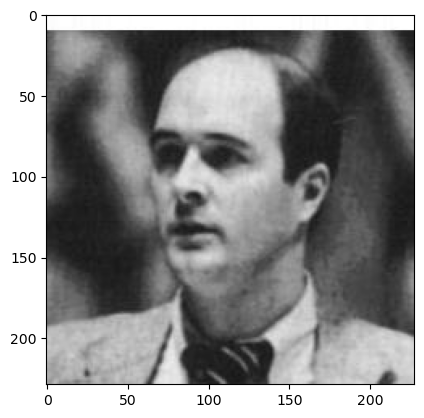

In [4]:
img = cv2.imread("./wiki_crop/01/10075401_1944-11-05_1982.jpg")    # смотрим вид изображения
plt.imshow(img)
plt.show()

In [5]:
#Обнаружение лиц на изображениях
from mtcnn import MTCNN
import cv2

def detect_faces(image_path):
    detector = MTCNN()
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(image)
    return faces, image

In [ ]:
import re
imgs = []
faces = []
labels = []  
os.makedirs(cropped_imgs, exist_ok=True)
for folder in tqdm(folders, desc="Сropped_imgs"):
    folder_path = os.path.join(base_dir, folder)
    
    for img_name in os.listdir(folder_path):
        if not img_name.endswith('.jpg'):
            continue
            
        img_path = os.path.join(folder_path, img_name)
        
        try:
            detected_faces, image = detect_faces(img_path)
            
            if not detected_faces:
                continue
                
            # Извлекаем годы из имени файла
            years = re.findall(r'_(\d{4})', img_name)
            if len(years) < 2:
                continue
                
            birth_year, target_year = int(years[0]), int(years[1])
            age = target_year - birth_year
            
            # Обрабатываем каждое обнаруженное лицо
            for i, face in enumerate(detected_faces):
                # Изменяем размер изображения
                resized_img = cv2.resize(image, (224, 224))
                
                # Сохраняем обработанное изображение
                base_name = os.path.splitext(img_name)[0]
                cropped_imgs_name = f"{base_name}_face{i}.jpg"
                cropped_imgs_path = os.path.join(cropped_imgs, cropped_imgs_name)
                cv2.imwrite(cropped_imgs_path, cv2.cvtColor(resized_img, cv2.COLOR_RGB2BGR))
                
                # Добавляем в списки для дальнейшей обработки
                imgs.append(resized_img)
                labels.append(age)
                
        except Exception as e:
            print(f"ERROR processing {img_path}: {str(e)}")
            continue

# Преобразуем в numpy array и нормализуем
if imgs:
    imgs = np.array(imgs).astype('float32') / 255.0
    labels = np.array(labels)
else:
    print("No images were processed!")
    imgs = np.array([])
    labels = np.array([])

In [ ]:
#Использование MTCNN не увенчалось успехом. Было благополучно потрачено 1.5 дня.
#Прервал через 1043m :(
#Сropped_imgs:  34%|███▍      | 34/100 [17:23:04<33:44:47, 1840.73s/it]

In [5]:
# initialize constants
FOLDER_PATH = './wiki_crop'
CROPPED_IMGS_FOLDER = 'cropped_imgs'

INPUT_SHAPE = (224, 224, 3,)
SIZE_TH = 0.25
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.1
BATCH_SIZE = 32

In [ ]:
# Используем Mediapipe
imgs_df = pd.DataFrame(columns=['filename', 'raw', 'class'])

cropped_imgs_path = os.path.join(FOLDER_PATH, CROPPED_IMGS_FOLDER)
if not os.path.exists(cropped_imgs_path):
    os.mkdir(cropped_imgs_path)

with mp.solutions.face_detection.FaceDetection(
    min_detection_confidence=0.6, model_selection=1) as face_model:

    for num_folder in tqdm(os.listdir(FOLDER_PATH)):
        num_folder_path = os.path.join(FOLDER_PATH, num_folder)

        if not os.path.isdir(num_folder_path):
            continue

        for img_name in os.listdir(num_folder_path):
            img = cv2.imread(os.path.join(num_folder_path, img_name),
                             cv2.IMREAD_COLOR_RGB)
            try:
                imgh, imgw, _ = img.shape
            except AttributeError:
                continue
            try:
                birth_year, photo_year = img_name.split('_')[1:]
                birth_year = int(birth_year.split('-')[0])
                photo_year = int(photo_year.split('.')[0])
                crop_class = photo_year - birth_year
            
                if crop_class <= 0 or crop_class >= 100:
                 continue

                result = face_model.process(img)
                if not result.detections:
                    continue

                for (n, detection) in enumerate(result.detections):
                    bbox = detection.location_data.relative_bounding_box
                    xmin = math.floor(bbox.xmin * imgw)
                    ymin = math.floor(bbox.ymin * imgh)
                    width = math.ceil(bbox.width * imgw)
                    height = math.ceil(bbox.height * imgh)

                    if width / INPUT_SHAPE[0] > SIZE_TH and \
                     height / INPUT_SHAPE[1] > SIZE_TH:
                        continue

                    cropped_img = img[ymin:ymin + height, xmin:xmin + width]
                    if cropped_img.shape == () or 0 in cropped_img.shape:
                        continue
                    resize_img = cv2.resize(cropped_img, (64, 64))

                    cropped_name = f'{num_folder}_{img_name.split(".")[0]}{n}.jpg'
                    cv2.imwrite(os.path.join(FOLDER_PATH, CROPPED_IMGS_FOLDER, cropped_name),
                              cv2.cvtColor(resize_img, cv2.COLOR_RGB2BGR))

                    if imgs_df.empty:
                        imgs_df = pd.DataFrame(dict(zip(imgs_df.columns,
                        [cropped_name, crop_class, np.log(crop_class)])), index=[0])
                    else:
                        imgs_df = imgs_df._append(pd.Series(dict(zip(imgs_df.columns,
                        [cropped_name, crop_class, np.log(crop_class)]))), ignore_index=True)
            except:
                print("Error")
                continue

 62%|██████▏   | 63/101 [04:41<02:00,  3.17s/it]

Error


 99%|█████████▉| 100/101 [06:22<00:02,  2.66s/it]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Erro

100%|██████████| 101/101 [06:42<00:00,  3.98s/it]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


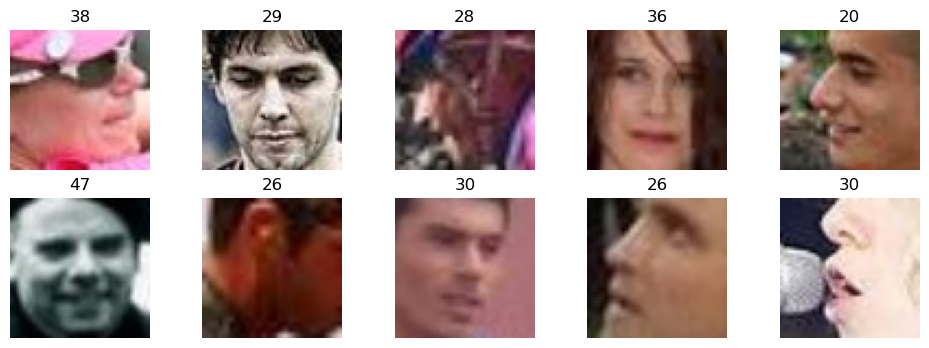

In [7]:
# show cropped images from dataset
plt.figure(figsize=(12, 4))

for i in range(10):
    img_path = os.path.join(FOLDER_PATH, CROPPED_IMGS_FOLDER,
                            imgs_df.loc[i, 'filename'])
    img = cv2.imread(img_path, cv2.IMREAD_COLOR_RGB)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(str(imgs_df.loc[i, 'raw']))
    plt.axis('off')

In [ ]:
# Сохранение в CSV
imgs_df.to_csv("filename.csv", index=False)

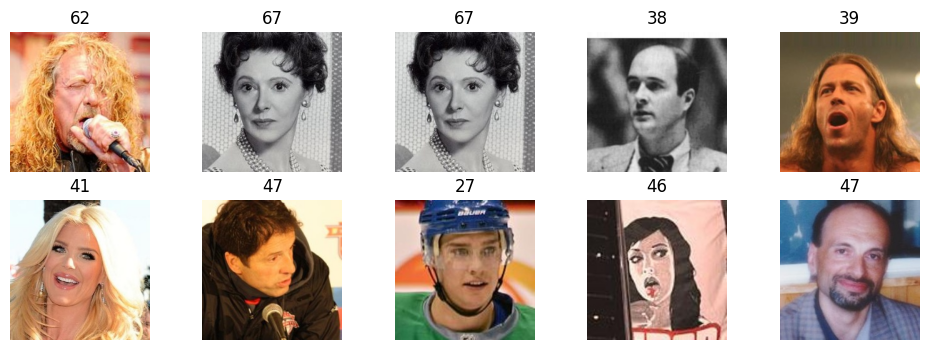

In [19]:
# show images from dataset
plt.figure(figsize=(12, 4))
i = 1

for img_name in os.listdir(cropped_imgs):
    if i > 10:
        break
    
    img = cv2.imread(os.path.join(cropped_imgs, img_name),
                         cv2.IMREAD_COLOR_RGB)
    try:
        h, w, _ = img.shape
    except AttributeError:
        continue
    if h < 10 or w < 10:
        continue
    
    years = re.findall(r'_(\d{4})', img_name)
    if len(years) < 2:
        continue
                
    birth_year, target_year = int(years[0]), int(years[1])
      
    age = target_year - birth_year

    if 0 < age < 100:
        plt.subplot(2, 5, i)
        plt.imshow(img)
        plt.title(str(age))
        plt.axis('off')
        i += 1

     

In [42]:
print("Images shape: ", imgs.shape)   # выводим размеры датасета
print("Labels shape: ", labels.shape)

Images shape:  (27000, 64, 64, 3)
Labels shape:  (27000, 10)


In [43]:
# разбиваем на тестовую и тренировочную выборку
X_test = imgs[:1500]
y_test = labels[:1500]
X_train = imgs[1500:]
y_train = labels[1500:]
print("Train images shape: ", X_train.shape)
print("Test images shape: ", X_test.shape)
print("Train labels shape: ", y_train.shape)
print("Test labels shape: ", y_test.shape)

Train images shape:  (25500, 64, 64, 3)
Test images shape:  (1500, 64, 64, 3)
Train labels shape:  (25500, 10)
Test labels shape:  (1500, 10)


In [44]:
# Добавим валидационную выборку
X_valid, X_train = X_train[:3000], X_train[3000:]
y_valid, y_train = y_train[:3000], y_train[3000:]
print("Train images shape: ", X_train.shape)
print("Valid images shape: ", X_valid.shape)
print("Train labels shape: ", y_train.shape)
print("Valid labels shape: ", y_valid.shape)

Train images shape:  (22500, 64, 64, 3)
Valid images shape:  (3000, 64, 64, 3)
Train labels shape:  (22500, 10)
Valid labels shape:  (3000, 10)


In [45]:
from transformers import TFViTForImageClassification, ViTImageProcessor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')  # Отключаем GPU (если используется)
tf.config.experimental_run_functions_eagerly(True)  # Включаем eager execution

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = TFViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=10, ignore_mismatched_sizes=True)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.
Some weights of TFViTForImageClassification were not initialized from the model checkpoint are newly initialize

In [47]:
# Предобработка изображений
from PIL import Image
def preprocess_image(image):
    image = Image.fromarray((image * 255).astype('uint8'))
    inputs = processor(images=image, return_tensors="tf")
    return inputs["pixel_values"][0]

X_train = np.array([preprocess_image(img) for img in X_train])
X_valid = np.array([preprocess_image(img) for img in X_valid])
X_test = np.array([preprocess_image(img) for img in X_test])

In [48]:
# Создание tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

In [49]:
import keras
from keras.callbacks import ReduceLROnPlateau
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model/my_keras_model_{epoch}_{loss}.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

In [50]:
# Компиляция модели
model.compile(
    #optimizer=Adam(learning_rate=0.01),  
    loss=CategoricalCrossentropy(from_logits=True), 
    #metrics=[Accuracy()]  
)

In [57]:
# обучение модели

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=20,
    #callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/20



 77/704 [==>...........................] - ETA: 1:30:22 - loss: 2.3808

KeyboardInterrupt: 

In [ ]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

In [ ]:
# Оценка модели
results = model.evaluate(test_dataset)
print(f"Test accuracy: {results[1] * 100:.2f}%")